In [1]:
# Topological Initialization for Multidimensional Scaling
# Melinda Kleczynski, Anthony J. Kearsley
# Finalized April 17, 2025 

# Data from: https://cave.cs.columbia.edu/repository/COIL-100

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random 

from math import atan2
from PIL import Image
from scipy.optimize import least_squares 
from scipy.spatial.distance import pdist, squareform 
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression 
from sklearn.manifold import MDS 

import timds 

In [3]:
def read_image(object_number, image_index):

    fpath = 'coil-20-proc\\obj' + str(object_number) + '__' + str(image_index) + '.png'  
    image = np.asarray(Image.open(fpath))   

    return image/np.max(image) 

def add_noise(clean_image, seed = None):   

    rng = np.random.default_rng(seed = seed) 
    random_array = rng.uniform(low = 0, high = 1, size = np.shape(clean_image))  

    noisy_image = np.copy(clean_image)  
    noisy_image[random_array < 0.05] = 0 
    noisy_image[random_array > 0.95] = 1 

    return noisy_image

def shift_pred_angles(real_angles, input_pred_angles):  

    pred_angles = np.array(input_pred_angles)  # in case input is list 
    n_shifts = np.zeros(len(input_pred_angles), int)

    for i in range(10):  # max number of iterations

        pts_for_clustering = np.transpose(np.vstack([real_angles, pred_angles]))
        cluster_results = AgglomerativeClustering(distance_threshold = 1,
                                                  n_clusters = None, 
                                                  metric = 'euclidean', 
                                                  linkage = 'single').fit(pts_for_clustering)
        if i == 0:
            original_cluster_labels = np.copy(cluster_results.labels_)
        if cluster_results.n_clusters_ == 1:
            break 
        
        cluster_labels = cluster_results.labels_

        cluster_mean_ys = [np.mean(pred_angles[cluster_labels == label]) for label in np.unique(cluster_labels)]
        lower_cluster = np.argmin(cluster_mean_ys)

        pred_angles[cluster_labels == lower_cluster] += 2*np.pi 
        n_shifts[cluster_labels == lower_cluster] += 1

    return original_cluster_labels, pred_angles, n_shifts

In [4]:
n_images = 72

In [5]:
# images ordered by ground truth angle; shuffle to hide ground truth 
shuffled_image_indices = [i for i in range(n_images)] 
random.seed(0) 
random.shuffle(shuffled_image_indices) 
image_rotation = np.pi - (2*np.pi/n_images) * np.array(shuffled_image_indices) 

In [6]:
init_names = ['Random', 'PCA', 'Topological']

In [7]:
object_number = 1
example_name = 'Toy Duck' 
metric = 'euclidean' 

In [8]:
images = [read_image(object_number, index) for index in shuffled_image_indices] 
images = [add_noise(images[i], seed = i) for i in range(len(images))]
image_data = np.vstack([image.flatten() for image in images]) 
image_pdist = squareform(pdist(image_data, metric = metric))

# get initializations 
pca_coords = PCA(n_components = 2).fit_transform(image_data)
top_init_coords, bc1, cycle_diameter = timds.get_top(image_pdist)

# run mds  
mds_algs = [MDS(n_components = 2, dissimilarity = 'precomputed', random_state = 0), 
            MDS(n_components = 2, dissimilarity = 'precomputed', n_init = 1),
            MDS(n_components = 2, dissimilarity = 'precomputed', n_init = 1)] 
mds_coords = [mds_algs[0].fit_transform(image_pdist),
                mds_algs[1].fit_transform(image_pdist, init = pca_coords),
                mds_algs[2].fit_transform(image_pdist, init = top_init_coords)] 

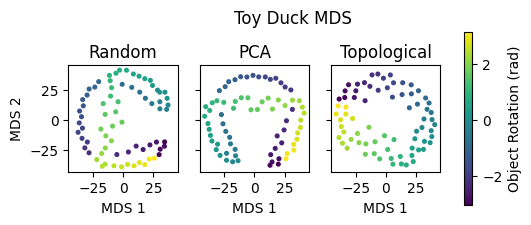

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (6, 2.25), sharex = True, sharey = True) 

for m in range(3): 

    cbar_plt = ax[m].scatter(mds_coords[m][:, 0], mds_coords[m][:, 1], s = 7, c = image_rotation) 

    ax[m].set_aspect('equal')
    ax[m].set_title(init_names[m])
    ax[m].set_xlabel('MDS 1')  

ax[0].set_ylabel('MDS 2')

cbar = plt.colorbar(cbar_plt, ax = ax)
cbar.set_label('Object Rotation (rad)')

plt.suptitle(example_name + ' MDS')  
plt.show()

### Circular coordinate recovery

In [10]:
# approximate center and radius for start of optimization 
a_start = 0 
b_start = 0
R_start = cycle_diameter/2
params_start = a_start, b_start, R_start

In [11]:
def circle_loss(circle_params, xy_coords):

    a, b, R = circle_params

    xs = xy_coords[:, 0]
    ys = xy_coords[:, 1]

    rs = [np.sqrt((xs[i] - a)**2 + (ys[i] - b)**2) for i in range(len(xs))]  
    resids = rs - R 

    return resids

In [12]:
def get_best_center(xy_coords):  

    circle_center_x, circle_center_y, circle_radius = least_squares(circle_loss, params_start, args = [xy_coords]).x

    return [circle_center_x, circle_center_y]

In [13]:
def get_lscircle_angle(point_x, point_y, circle_center_coords):

    rel_x = point_x - circle_center_coords[0] 
    rel_y = point_y - circle_center_coords[1]

    return atan2(rel_y, rel_x)

def get_lscircle_angles(xy_coords, circle_center_coords):

    return [get_lscircle_angle(xy_coords[i, 0], xy_coords[i, 1], circle_center_coords) 
            for i in range(np.shape(xy_coords)[0])] 

In [14]:
mds_best_centers = [get_best_center(mds_coords[m]) for m in range(3)]

In [15]:
mds_lscircle_angles = [get_lscircle_angles(mds_coords[m], mds_best_centers[m]) for m in range(3)]

In [16]:
shifting_results = [shift_pred_angles(image_rotation, mds_lscircle_angles[m]) for m in range(3)] 

In [17]:
Rsqs = np.zeros(3)

for m in range(3):

    x = image_rotation.reshape(-1, 1)
    y = shifting_results[m][1].reshape(-1, 1)
    Rsqs[m] = LinearRegression().fit(x, y).score(x, y)

In [18]:
Rsqs

array([0.00175125, 0.00217419, 0.99590252])

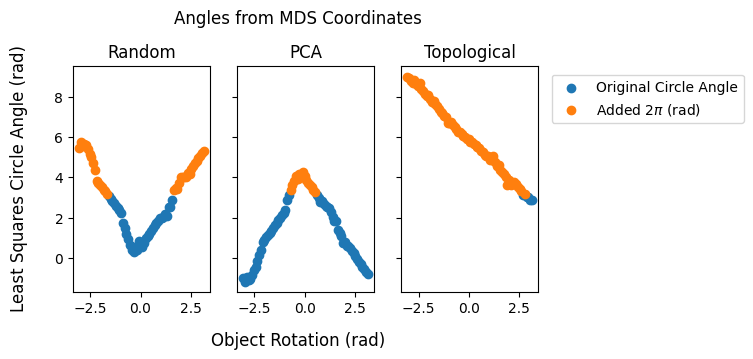

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (6, 3.5), sharey = True)

for m in range(3):

    y = shifting_results[m][1]
    n_shifts = shifting_results[m][2]

    ax[m].set_aspect('equal')
    ax[m].set_title(init_names[m])

    for s in np.unique(n_shifts):   
        if s == 0:
            label = 'Original Circle Angle' 
        else: 
            label = 'Added ' + str(2*s) + r'$\pi$' + ' (rad) '
        ax[m].scatter(image_rotation[n_shifts == s], y[n_shifts == s], label = label)

legend = ax[2].legend(loc = (1.1, 0.75))  

fig.supxlabel('Object Rotation (rad)') 
fig.supylabel('Least Squares Circle Angle (rad)')
fig.suptitle('Angles from MDS Coordinates')

plt.show()